In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥1.0.2 is required
import sklearn
assert sklearn.__version__ >= "1.0.2"

# Common imports
import numpy as np
import os
import pandas as pd
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)

In [2]:
# read data from csv file
trainset = pd.read_csv("C:/Users/21294596/OneDrive - Curtin/Coding/Phree_t1/April/Dataset_Train_Test/trainset_1.csv")
testset = pd.read_csv("C:/Users/21294596/OneDrive - Curtin/Coding/Phree_t1/April/Dataset_Train_Test/testset_1.csv")
print(trainset.shape)
print(testset.shape)

(8000, 18)
(2000, 18)


In [3]:
X_train = trainset.iloc[:, 0:11].values
y_train = trainset.iloc[:, 11:].values
X_test = testset.iloc[:, 0:11].values
y_test = testset.iloc[:, 11:].values

inputs = list(trainset.columns[0:11])
outputs = list(trainset.columns[11:])

print('Inputs: ', inputs)
print('Outputs: ', outputs)
print('X_train instances: ', X_train.shape)
print('X_test instances: ', X_test.shape)
print('y_train instances: ', y_train.shape)
print('y_test instances: ', y_test.shape)

Inputs:  ['pH', 'Mg Bound (Initial)', 'Mg Initial', 'Ca Bound (Initial)', 'Ca Initial', 'C(4) Bound (Initial)', 'C(4) Initial', 'Cl Bound (Initial)', 'Cl Initial', 'cal_ini_mol', 'dol_ini_mol']
Outputs:  ['C(4) Final', 'Ca Final', 'Mg Final', 'Cl Final', 'pH.1', 'Calcite', 'Dolomite']
X_train instances:  (8000, 11)
X_test instances:  (2000, 11)
y_train instances:  (8000, 7)
y_test instances:  (2000, 7)


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

norm_pipeline = Pipeline([
        ('minmax_scaler', MinMaxScaler((-1,1))),
    ])

X_train_norm = norm_pipeline.fit_transform(X_train)
X_test_norm = norm_pipeline.transform(X_test)

In [5]:
import xgboost as xgb
import time
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try combinations of hyperparameters
    {'subsample': [0.2, 0.6, 1.0], 
     'learning_rate': [0.01, 0.05, 0.1],
     'n_estimators': [300, 400, 500], 
     'max_depth': [3, 5, 10],
     'colsample_bytree': [0.6, 0.8, 1.0],
     'reg_lambda': [10, 1.0, 1e-1]}  
    ]

# train across 3 folds
grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', n_jobs=3, random_state=42),
                           param_grid, 
                           cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, 
                           verbose = 1,
                           n_jobs= 25)

start = time.time()
grid_search.fit(X_train_norm, y_train)
print("Run time = ", time.time()-start)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Run time =  2807.04843378067


In [6]:
print(f"best parameters: {grid_search.best_params_}")
print(f"best score:      {-grid_search.best_score_:0.5f} (+/-{grid_search.cv_results_['std_test_score'][grid_search.best_index_]:0.5f})")

best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'reg_lambda': 0.1, 'subsample': 0.6}
best score:      0.00076 (+/-0.00002)


In [7]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score
646,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",1,-5.456235e-08,1.966712e-09,-0.000756,0.000024
637,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",2,-1.612709e-07,1.369353e-08,-0.000756,0.000024
628,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",3,-7.210170e-07,5.939057e-08,-0.000757,0.000024
718,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",4,-4.208938e-08,3.833454e-11,-0.000874,0.000029
727,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",5,-4.029386e-08,3.983017e-10,-0.000874,0.000029
...,...,...,...,...,...,...
62,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",725,-4.476123e-02,1.274186e-04,-0.082515,0.000279
1,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",726,-8.181805e-02,4.495314e-04,-0.084355,0.001064
54,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",727,-8.602408e-02,1.446840e-04,-0.089497,0.002404
27,"{'colsample_bytree': 0.6, 'learning_rate': 0.0...",728,-8.678652e-02,1.431422e-04,-0.089622,0.002392


In [8]:
reg_best = grid_search.best_estimator_

print(grid_search.best_params_, end='\n')
print(grid_search.best_estimator_)

{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'reg_lambda': 0.1, 'subsample': 0.6}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=3,
             num_parallel_tree=None, random_state=42, ...)


In [9]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.3111712675354645 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 10, 'subsample': 0.2}
0.29043993016925873 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 10, 'subsample': 0.6}
0.28288947798141156 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 10, 'subsample': 1.0}
0.2784341285906758 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 1.0, 'subsample': 0.2}
0.27602076180125207 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 1.0, 'subsample': 0.6}
0.27529025204175334 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 1.0, 'subsample': 1.0}
0.2755543487886817 {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 0.1, 'subsample': 0.2}
0.275

In [10]:
sorted(zip(np.sqrt(-cvres["mean_test_score"]), cvres["params"]), key=lambda cvres: cvres[0], reverse=False)

[(0.027497093267015653,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.05,
   'max_depth': 10,
   'n_estimators': 500,
   'reg_lambda': 0.1,
   'subsample': 0.6}),
 (0.02749949742469245,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.05,
   'max_depth': 10,
   'n_estimators': 400,
   'reg_lambda': 0.1,
   'subsample': 0.6}),
 (0.027505921971181964,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.05,
   'max_depth': 10,
   'n_estimators': 300,
   'reg_lambda': 0.1,
   'subsample': 0.6}),
 (0.029559067575428047,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.1,
   'max_depth': 10,
   'n_estimators': 400,
   'reg_lambda': 0.1,
   'subsample': 0.6}),
 (0.029559070484761172,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.1,
   'max_depth': 10,
   'n_estimators': 500,
   'reg_lambda': 0.1,
   'subsample': 0.6}),
 (0.029559724553601632,
  {'colsample_bytree': 1.0,
   'learning_rate': 0.1,
   'max_depth': 10,
   'n_estimators': 300,
   'reg_lambda': 0.1,
   'subsample': 0.6}),
 (

In [11]:
#Training Set Accuracy score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

start = time.time()
y_train_pred = reg_best.predict(X_train_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_train, y_train_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_train, y_train_pred)
print('mae: ',mae)

r2_model = r2_score(y_train, y_train_pred)
print('\nR2: ',r2_model)

time =  -0.11821579933166504

mse:  9.229111519838908e-08
rmse:  0.0003037945279270005
mae:  0.00013439058973204346

R2:  0.9953571089370504


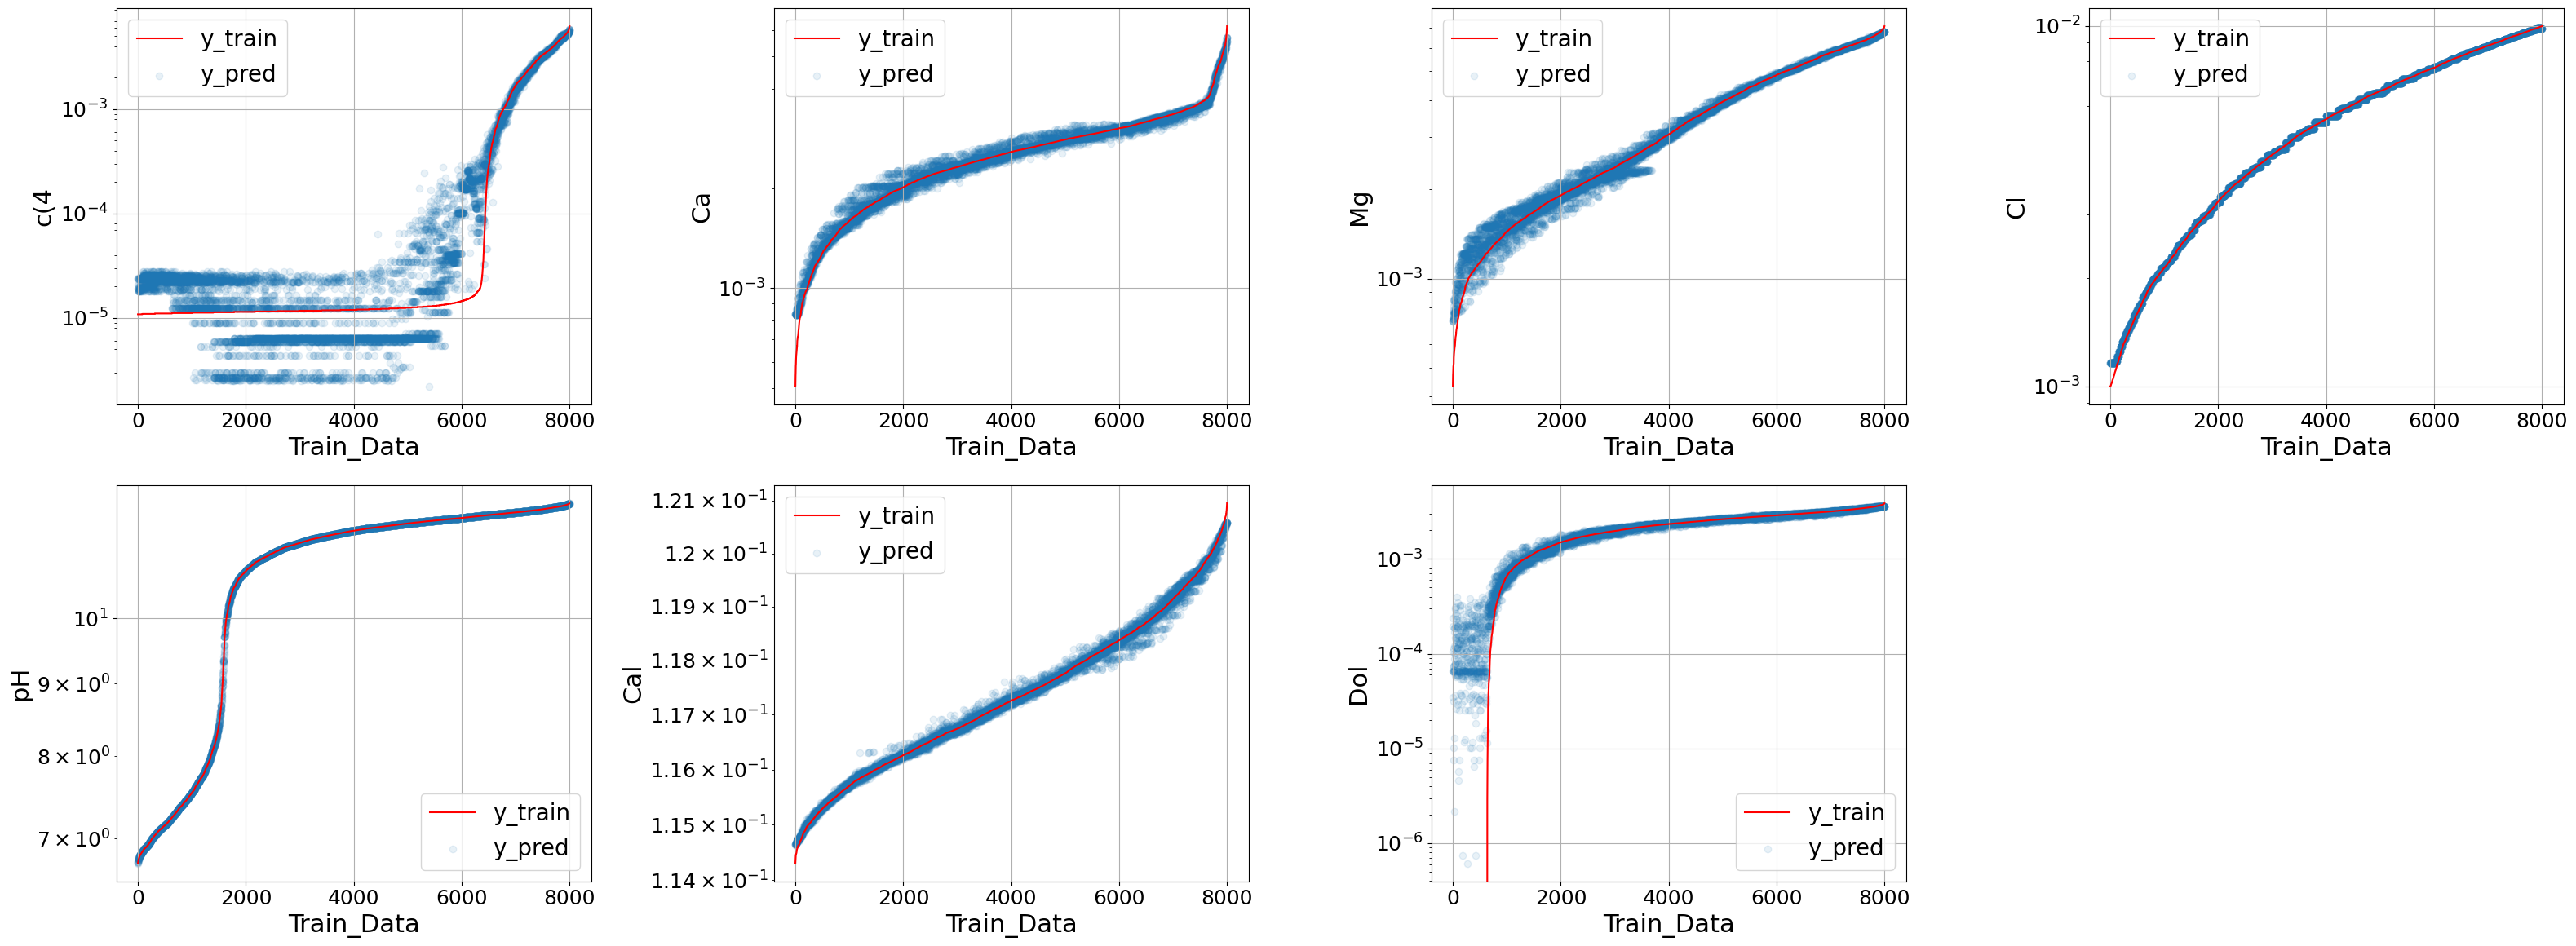

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Update font sizes
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('axes', labelsize=22)

# Assume 'outputs' is a list of output feature names
outputs = ["c(4)", "Ca", "Mg", "Cl","pH","Cal", "Dol"]  # Replace with actual feature names

num_outputs = len(outputs)  # Number of output features

# Calculate number of rows and columns for subplots
num_rows = 2
num_cols = (num_outputs + 1) // 2  # Round up to ensure enough space for all plots

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 8, num_rows * 6))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        output_index = i * num_cols + j  # Calculate index of output feature
        if output_index < num_outputs:
            aux_train = y_train[:, output_index]
            aux_pred = y_train_pred[:, output_index]
            index = np.argsort(aux_train)
            x = range(len(index))
            ax.plot(x, aux_train[index], 'r-')
            ax.scatter(x, aux_pred[index], alpha=0.1)
            ax.legend(['y_train', 'y_pred'])
            ax.set_xlabel('Train_Data')
            ax.  set_ylabel(outputs[output_index][:3])
            ax.grid()
            ax.set_yscale('log')  # Set y-axis to log scale

# If the number of output features is odd, remove the empty subplot
if num_outputs % 2 == 1:
    fig.delaxes(axes[num_rows - 1, num_cols - 1])

plt.tight_layout()
plt.show()

In [13]:
start = time.time()
y_test_pred = reg_best.predict(X_test_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_test, y_test_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_test, y_test_pred)
print('mae: ',mae)

r2_model = r2_score(y_test, y_test_pred)
print('\nR2: ',r2_model)

time =  -0.033910512924194336

mse:  0.0005178349735055636
rmse:  0.022755987640741143
mae:  0.002845185439886256

R2:  0.9944296713942737


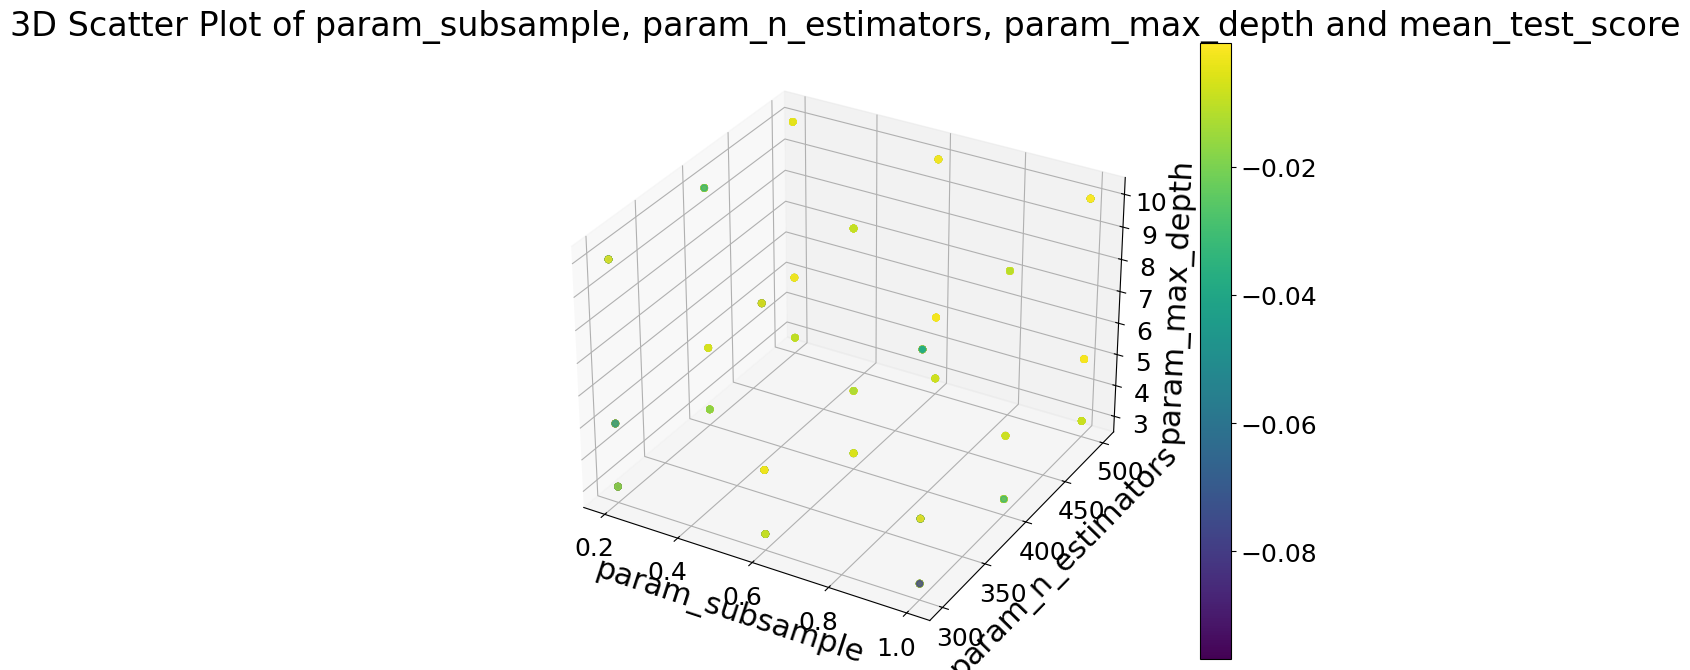

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter(data, x_param, y_param, z_param, score='mean_test_score'):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    sc = ax.scatter(data[x_param], data[y_param], data[z_param], c=data[score], cmap='viridis', marker='o')
    ax.set_xlabel(x_param)
    ax.set_ylabel(y_param)
    ax.set_zlabel(z_param)
    plt.title(f'3D Scatter Plot of {x_param}, {y_param}, {z_param} and {score}')
    plt.colorbar(sc)
    plt.show()

# Example: 3D scatter plot of max_features, max_depth, and min_samples_leaf
plot_3d_scatter(results_df, 'param_subsample', 'param_n_estimators', 'param_max_depth', score='mean_test_score')

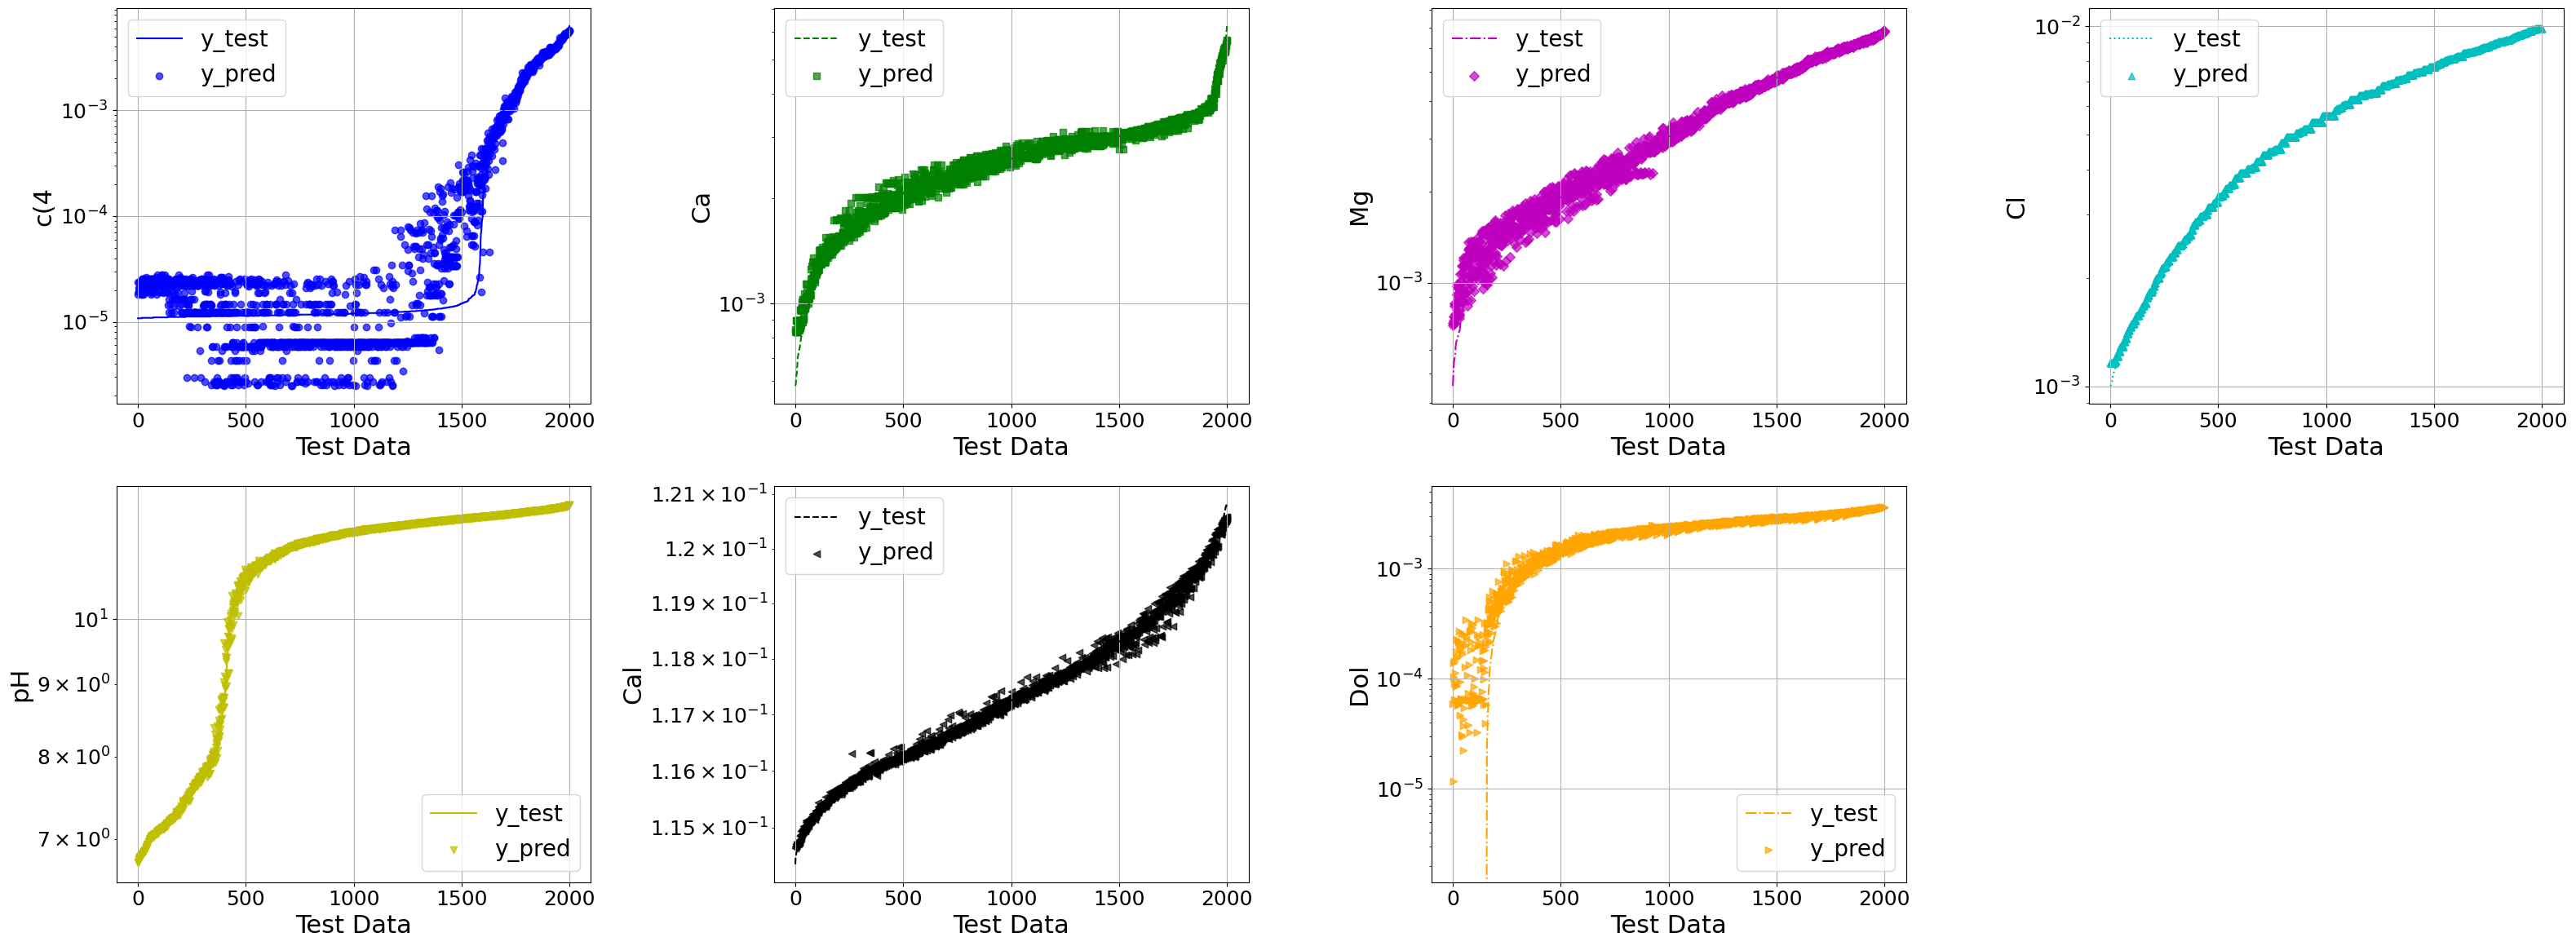

In [15]:
# Testing Data Accuracy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Update font sizes
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('axes', labelsize=22)

# Assume 'outputs' is a list of output feature names
outputs = ["c(4)", "Ca", "Mg", "Cl", "pH", "Cal", "Dol"]  # Replace with actual feature names

num_outputs = len(outputs)  # Number of output features

# Calculate number of rows and columns for subplots
num_rows = 2
num_cols = (num_outputs + 1) // 2  # Round up to ensure enough space for all plots

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 8, num_rows * 6))

# Define different colors, line styles, and markers
colors = ['b', 'g', 'm', 'c', 'y', 'k', 'orange']
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', 'D', '^', 'v', '<', '>']

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        output_index = i * num_cols + j  # Calculate index of output feature
        if output_index < num_outputs:
            aux_train = y_test[:, output_index]
            aux_pred = y_test_pred[:, output_index]
            index = np.argsort(aux_train)
            x = range(len(index))

            color = colors[output_index % len(colors)]
            line_style = line_styles[output_index % len(line_styles)]
            marker = markers[output_index % len(markers)]

            ax.plot(x, aux_train[index], line_style, color=color, label='y_test')
            ax.scatter(x, aux_pred[index], color=color, alpha=0.7, marker=marker, label='y_pred')
            ax.legend()
            ax.set_xlabel('Test Data')
            ax.set_ylabel(outputs[output_index][:3])
            ax.grid(True)
            ax.set_yscale('log')  # Set y-axis to log scale

# If the number of output features is odd, remove the empty subplot
if num_outputs % 2 == 1:
    fig.delaxes(axes[num_rows - 1, num_cols - 1])

plt.tight_layout()
plt.show()

In [17]:
 #Runtime

start = time.time()
for i in range(1000):  
    reg_best.predict(X_test_norm[0:1])
end = time.time()
print("time = ", (start - end)/1000)
print()

time =  -0.00038413596153259277



In [20]:
import joblib
final_model = Pipeline([
        ("norm", norm_pipeline),
        ("reg", reg_best)
        ])

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model.predict(X_test))))
joblib.dump(final_model, "XGmodel.pkl")

rmse:  0.022755987640741143


['XGmodel.pkl']

In [21]:
import joblib
from sklearn.metrics import mean_squared_error

#joblib.dump(final_model, "DTmodel.pkl")
final_model_loaded = joblib.load("DTmodel.pkl") 

print('rmse: ', np.sqrt(mean_squared_error(y_test, final_model_loaded.predict(X_test))))

rmse:  0.048941935004476654


In [22]:
start = time.time()
final_model_loaded = joblib.load("DTmodel.pkl") 
end_load = time.time()
print('Load time = ', end_load - start)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1])
end = time.time()    
print('Prediction time 1 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:1000])
end = time.time()    
print('Prediction time 1000 = ', (end - start)/1000)
start = time.time()
for i in range(1000):    
    y_pred = final_model_loaded.predict(X_test[0:10000])
end = time.time()    
print('Prediction time 10,000 = ', (end - start)/1000)

Load time =  0.0019979476928710938
Prediction time 1 =  0.0002032959461212158
Prediction time 1000 =  0.00038454413414001464
Prediction time 10,000 =  0.0004476597309112549


Load time =  0.0012140274047851562
Prediction time 1 =  0.00018621087074279785
Prediction time 1000 =  0.0003401286602020264
Prediction time 10000 =  0.00048383164405822754


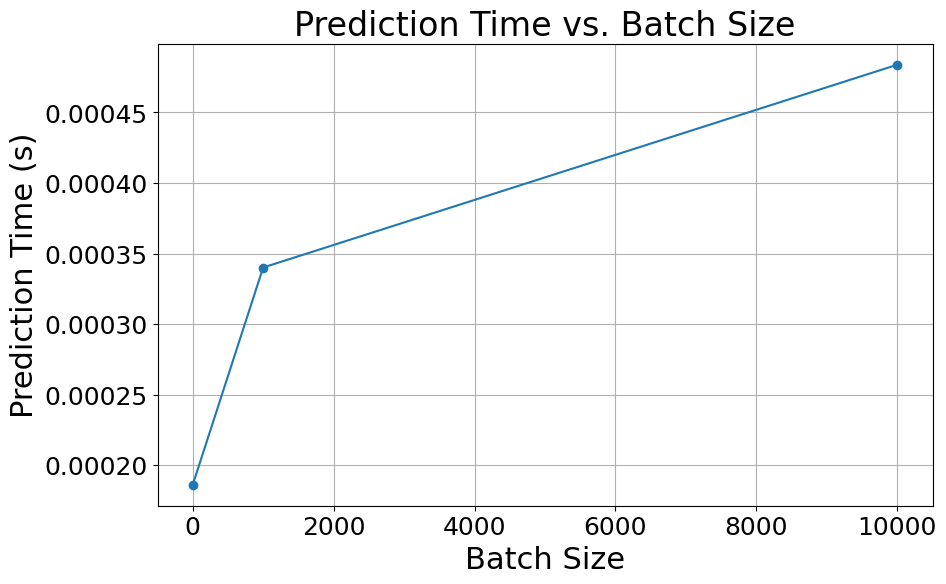

In [23]:
import time
import joblib
import matplotlib.pyplot as plt

# Load the model
start = time.time()
final_model_loaded = joblib.load("DTmodel.pkl")
end_load = time.time()
print('Load time = ', end_load - start)

# Define batch sizes
batch_sizes = [1, 1000, 10000]
prediction_times = []

# Measure prediction times for different batch sizes
for batch_size in batch_sizes:
    start = time.time()
    for _ in range(1000):
        y_pred = final_model_loaded.predict(X_test[:batch_size])
    end = time.time()
    prediction_times.append((end - start) / 1000)
    print(f'Prediction time {batch_size} = ', (end - start) / 1000)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, prediction_times, marker='o')
plt.title('Prediction Time vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Prediction Time (s)')
plt.grid(True)
plt.show()